# Data Science
- Sturdent: Dmytro Geleshko
- Group: IP-91
- Var: 6

## Task:
- Quadratic function
- Normal noise
- Anomalies
- LSM

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Config

In [2]:
np.random.seed(6)
plt.rcParams["figure.figsize"] = (20, 8)
pd.set_option('display.max_columns', None)

## Parameters

In [3]:
PARAM_selection_size = 1000
PARAM_anomaly_size = 0.1
PARAM_normal_mean = 0
PARAM_normal_std = 2
PARAM_max_pow = 3

## Functions

In [4]:
def describe_all(_data, trend_column):
    """Prints stats of all data in dictionary"""
    # create df
    df = pd.DataFrame(_data)
    # pop trend data
    trend_data = df.pop(trend_column)
    # remove trend from other data
    for column in df.columns:
        df[column] = df[column] - trend_data
    # find stats and calc var
    stats = df.describe()
    stats.loc["var"] = stats.loc["std"] ** 2
    return stats

In [5]:
def lsm(y):
    # Reshape y to row vector
    Y = y.reshape(-1, 1)
    # Creating F matrix, 1, x, x^2, ..., x^PARAM_max_pow
    F = np.ones((PARAM_selection_size, PARAM_max_pow + 1))
    for i in range(1, PARAM_max_pow + 1):
        # Pow to
        F[:, i] = np.power(np.arange(0, PARAM_selection_size), i)
    # Calculations
    FT = F.T
    FF = np.dot(FT, F)
    FFI = np.linalg.inv(FF)
    FFIFT = np.dot(FFI, FT)
    C = np.dot(FFIFT, Y)
    result = np.dot(F, C)
    # returning array, reshaped from row vector to 1d
    return result.reshape(-1)

## Errors and anomalies

In [6]:
_normal = np.random.normal(PARAM_normal_mean, PARAM_normal_std, PARAM_selection_size)

# adding anomalies at indexes, drawn from uniform distribution
_normal_anomaly = _normal.copy()
for i in np.unique(np.random.randint(0, PARAM_selection_size, int(PARAM_selection_size * PARAM_anomaly_size))):
    _normal_anomaly[i] *= 3

## Data

In [7]:
data = {}

# quadratic + noise + anomalies
data["quadratic"] = np.square(np.linspace(0, 5, PARAM_selection_size))
data["quadratic_normal"] = data["quadratic"].copy() + _normal
data["quadratic_normal_anomalies"] = data["quadratic"].copy() + _normal_anomaly

# lsm
data["quadratic_lsm"] = lsm(data["quadratic"])
data["quadratic_normal_lsm"] = lsm(data["quadratic_normal"])
data["quadratic_normal_anomalies_lsm"] = lsm(data["quadratic_normal_anomalies"])

# data stats
describe_all(data, "quadratic")

,quadratic_normal,quadratic_normal_anomalies,quadratic_lsm,quadratic_normal_lsm,quadratic_normal_anomalies_lsm
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000
mean,-0.017713,-0.057118,-1.410521e-12,-0.017713,-0.057118
std,1.930266,2.546910,4.346543e-13,0.073793,0.132522
min,-7.380471,-16.738802,-1.904255e-12,-0.132178,-0.263377
25%,-1.294266,-1.452863,-1.810552e-12,-0.079102,-0.180257
50%,-0.042946,-0.042946,-1.523670e-12,-0.028810,-0.059071
75%,1.304209,1.378016,-1.066869e-12,0.038094,0.065039
max,5.428759,14.034205,-4.693468e-13,0.141005,0.156934
var,3.725926,6.486749,1.889244e-25,0.005445,0.017562


## Plots

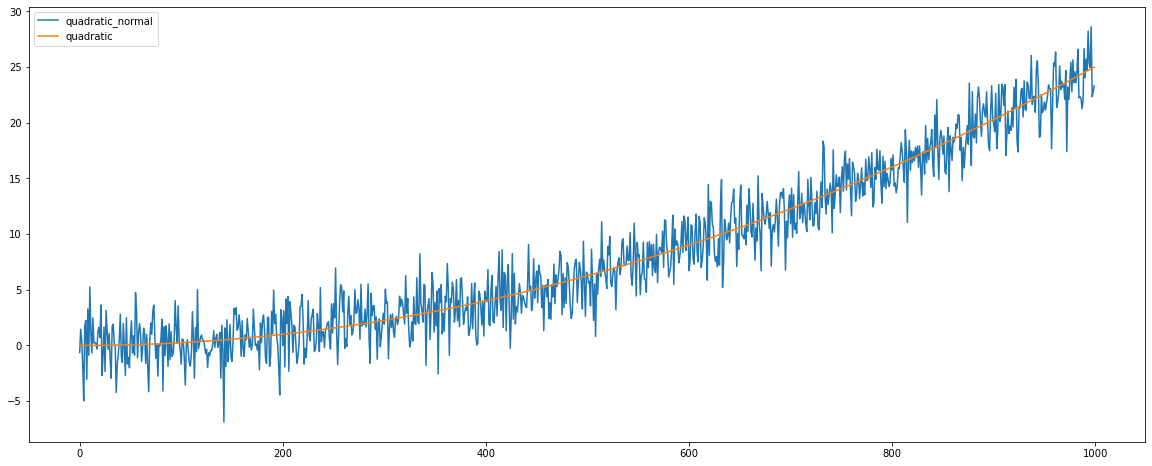

In [8]:
plt.plot(data["quadratic_normal"], label="quadratic_normal")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

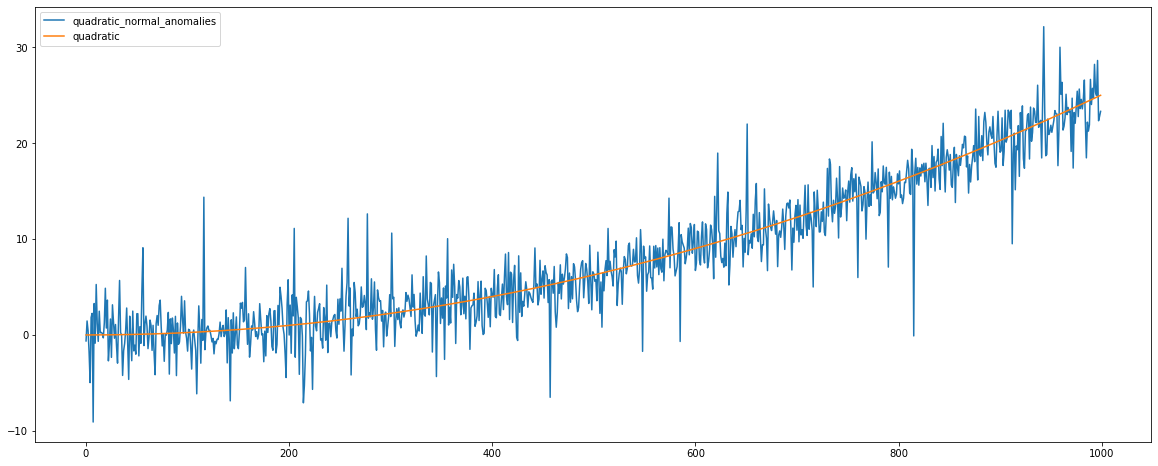

In [9]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

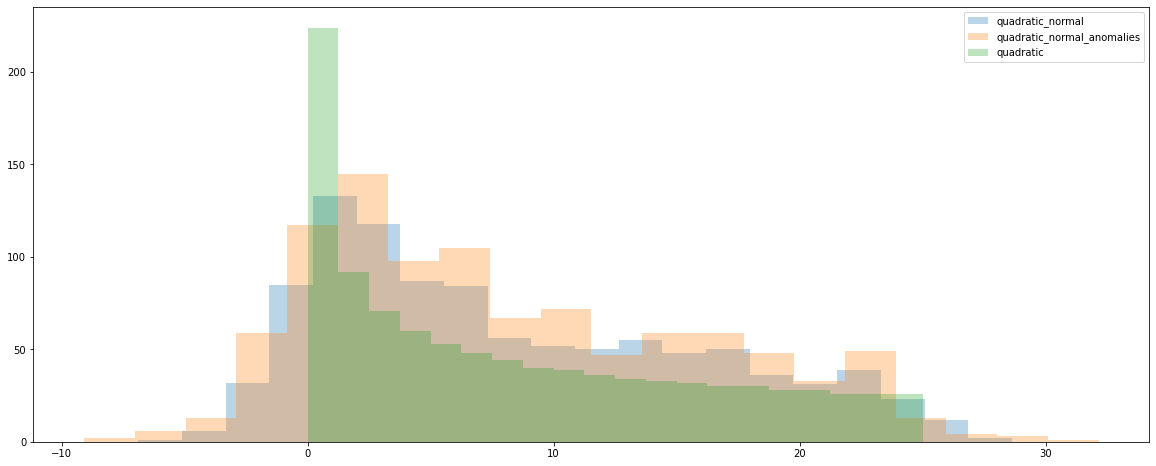

In [10]:
plt.hist(data["quadratic_normal"], bins=20, alpha=0.3, label="quadratic_normal")
plt.hist(data["quadratic_normal_anomalies"], bins=20, alpha=0.3, label="quadratic_normal_anomalies")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()

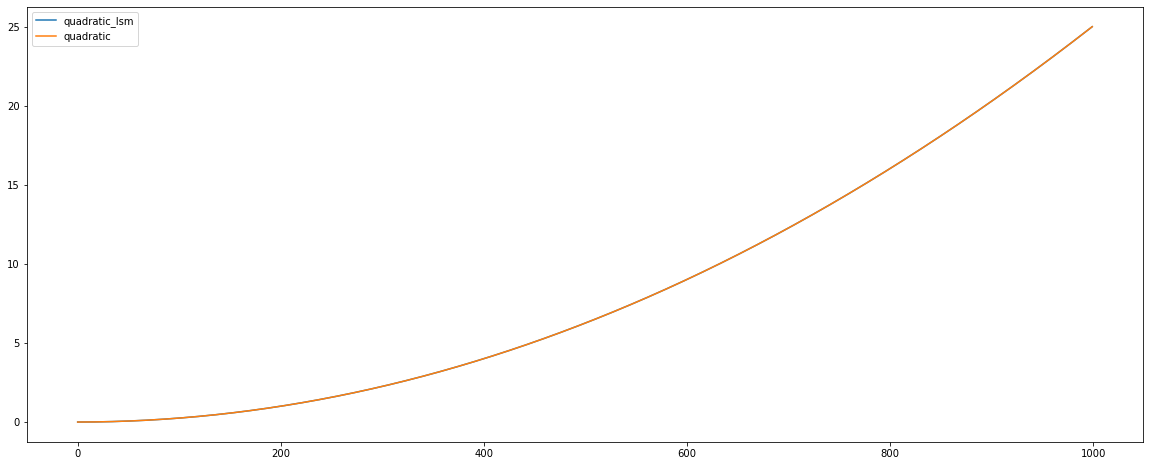

In [11]:
plt.plot(data["quadratic_lsm"], label="quadratic_lsm")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

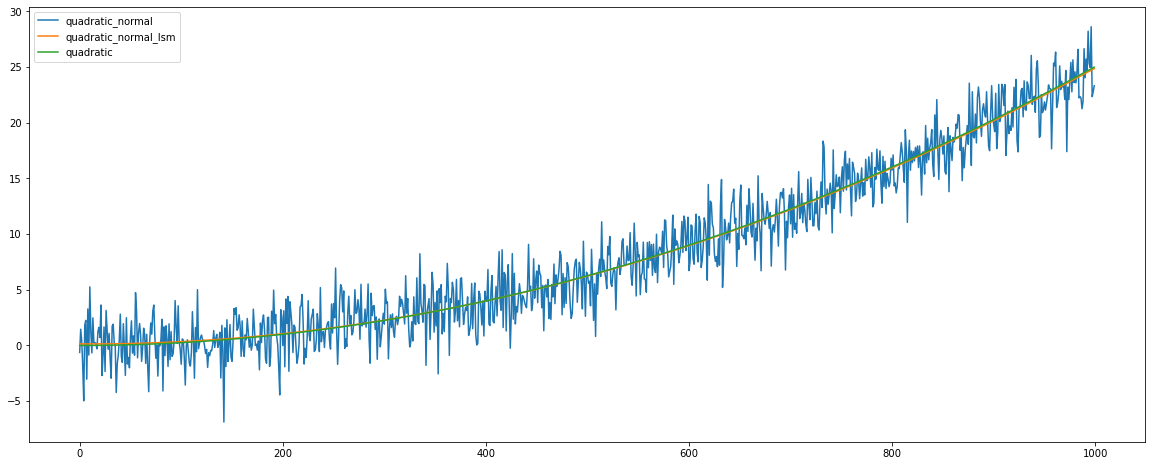

In [12]:
plt.plot(data["quadratic_normal"], label="quadratic_normal")
plt.plot(data["quadratic_normal_lsm"], label="quadratic_normal_lsm")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

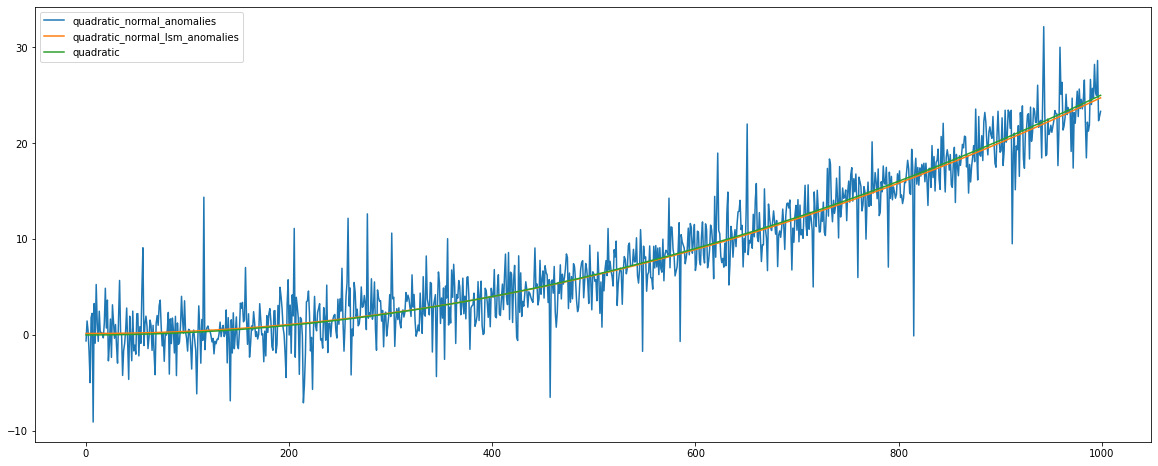

In [13]:
plt.plot(data["quadratic_normal_anomalies"], label="quadratic_normal_anomalies")
plt.plot(data["quadratic_normal_anomalies_lsm"], label="quadratic_normal_lsm_anomalies")
plt.plot(data["quadratic"], label="quadratic")
plt.legend()
plt.show()

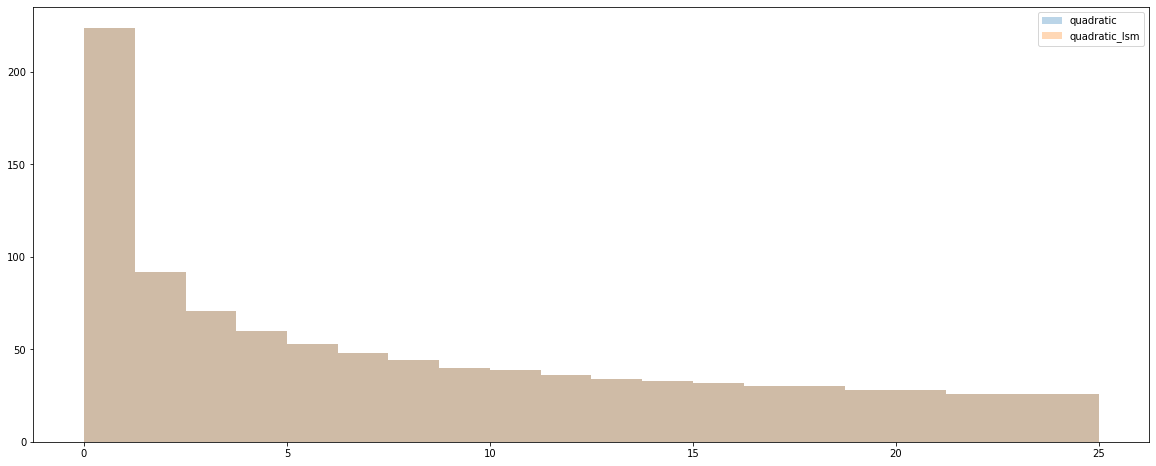

In [14]:
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.hist(data["quadratic_lsm"], bins=20, alpha=0.3, label="quadratic_lsm")
plt.legend()
plt.show()

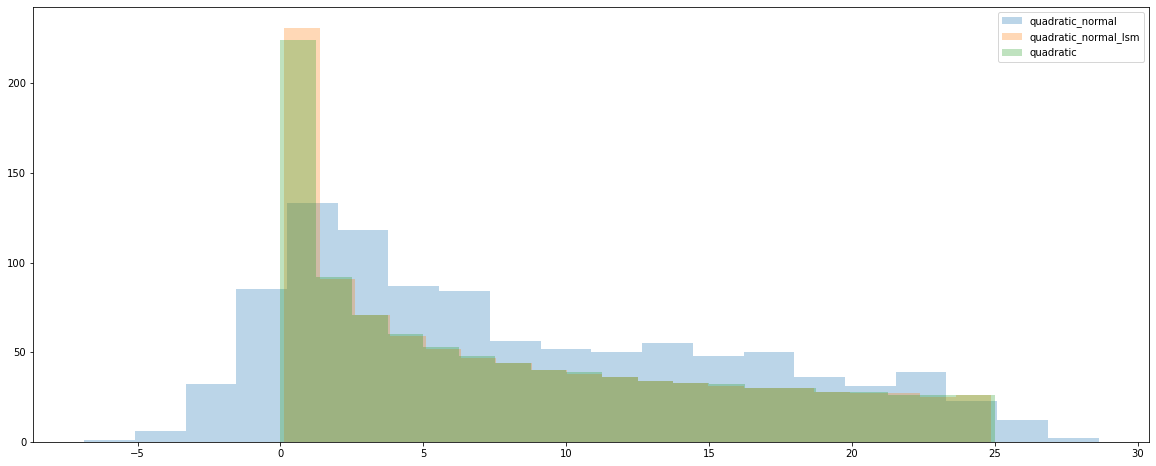

In [15]:
plt.hist(data["quadratic_normal"], bins=20, alpha=0.3, label="quadratic_normal")
plt.hist(data["quadratic_normal_lsm"], bins=20, alpha=0.3, label="quadratic_normal_lsm")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()

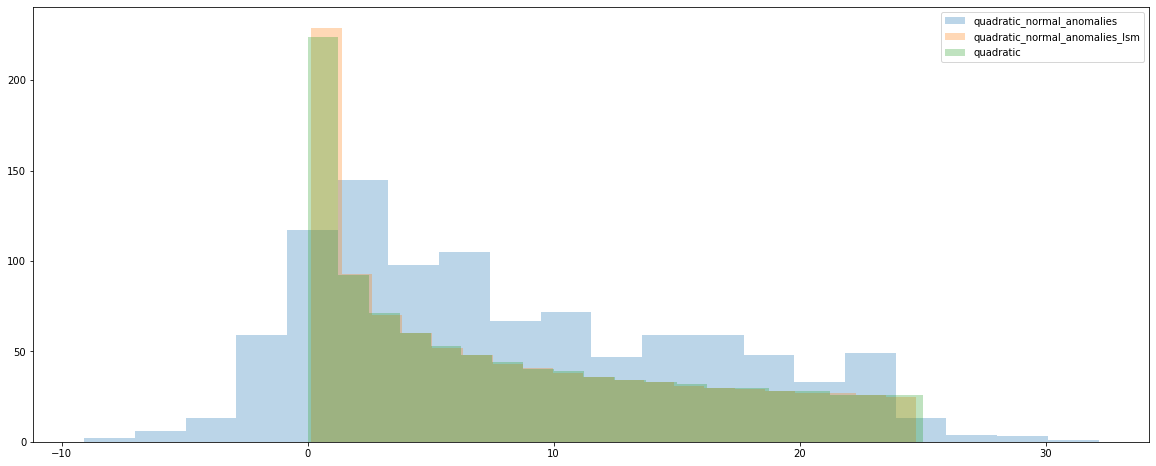

In [16]:
plt.hist(data["quadratic_normal_anomalies"], bins=20, alpha=0.3, label="quadratic_normal_anomalies")
plt.hist(data["quadratic_normal_anomalies_lsm"], bins=20, alpha=0.3, label="quadratic_normal_anomalies_lsm")
plt.hist(data["quadratic"], bins=20, alpha=0.3, label="quadratic")
plt.legend()
plt.show()